In [1]:
%pip install scipy
%pip install ipyparallel

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
from plot_toomre_q_projection import field_from_sliceplot
from smartstar_find import ss_properties
from helper_functions import _make_disk_L
from plot_multi_projections import tidy_data_labels
from yt.utilities.math_utils import ortho_find
from plot_radial_profile_from_frb import extract_dd_segment, extract_simulation_name
from find_fourier_modes import get_theta_values, find_bar_radius, extract_dd_number
#from plot_density_slices_toomreq import find_fourier_modes_and_phase_angles
from multiprocessing import Pool, cpu_count
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import yt

In [44]:
def find_fourier_modes_and_phase_angles(radii, radius_pc, densities, theta, dV, dr=0.001, cylindrical_theta_velocity=None):
    """
    Compute the m=1, 2 Fourier mode strengths and phase angles for a given annular region of a disk.
    Input:
        radii: list of radii for annular regions
        radius_pc: 2D array of radii values for each cell in the disk
        densities: 2D array of densities values for each cell in the disk
        theta: 2D array of theta values for each cell in the disk
        dV: volume of each cell in the disk
        dr: thickness of annular regions
    Output:
        m1_strengths: list of m=1 Fourier mode strengths for each annular region
        m2_strengths: list of m=2 Fourier mode strengths for each annular region
        phi_1_values: list of m=1 Fourier mode phase angles for each annular region
        phi_2_values: list of m=2 Fourier mode phase angles for each annular region
    """
    m1_strengths = []
    m2_strengths = []
    phi_1_values = []
    phi_2_values = []
    angular_speeds = []
    for r in radii:
        # Define mask for annular region
        mask = (radius_pc >= r) & (radius_pc < r + dr)

        # Get densities and thetas for this annular region, where 0 < theta < 2pi - all same shape (713,)
        masked_densities = densities[mask]
        theta_2d = np.tile(theta, (densities.shape[0], 1))
        masked_theta = theta_2d[mask]
        if cylindrical_theta_velocity is not None:
            masked_theta_vel = cylindrical_theta_velocity[mask]
            angular_speed = masked_theta_vel / (r*yt.units.pc).to("cm")
            angular_speeds.append(angular_speed)

        # Compute the mass-equivalent for each cell in this region
        mass_equivalent = masked_densities * dV

        # Compute a and b coefficients for m=2 and m=1 modes
        a_2 = np.sum(mass_equivalent * np.cos(2 * masked_theta))
        b_2 = np.sum(mass_equivalent * np.sin(2 * masked_theta))
        a_1 = np.sum(mass_equivalent * np.cos(masked_theta))
        b_1 = np.sum(mass_equivalent * np.sin(masked_theta))

        # Compute A_0 for this region
        A_0 = np.sum(mass_equivalent)

        # Compute Fourier modes for this region
        A_2 = np.sqrt(a_2**2 + b_2**2)
        A_1 = np.sqrt(a_1**2 + b_1**2)

        # Normalise the Fourier mode strengths for this region
        m2_strength = A_2 / A_0 if A_0 != 0 else 0
        m1_strength = A_1 / A_0 if A_0 != 0 else 0
        m2_strengths.append(m2_strength)
        m1_strengths.append(m1_strength)

        # Compute the phase angle phi_2 for this region
        phi_2 = 0.5 * np.degrees(np.arctan2(b_2, a_2).value) # -90 < phi_2 < 90
        phi_1 = np.degrees(np.arctan2(b_1, a_1).value) # -180 < phi_1 < 180
        phi_2_values.append(phi_2)
        phi_1_values.append(phi_1)
    
    if cylindrical_theta_velocity is not None:
        return m1_strengths, m2_strengths, phi_1_values, phi_2_values, angular_speeds
    
    return m1_strengths, m2_strengths, phi_1_values, phi_2_values

# Inspecting theta values
ds = yt.load("/ceph/cephfs/sgordon/pleiades/seed1-bh-only/270msun/replicating-beckmann/1B.m16-4dx/DD0140/DD0140")
dx = ds.index.get_smallest_dx().to("pc")
center, ss_mass, ss_age = ss_properties(ds, velocity=False)
radii = np.arange(0.001, 0.1, 0.001)
disc_h_pc = disc_r_pc = 0.1 # pc
_, L = _make_disk_L(ds, center, disc_r_pc, disc_h_pc)
vecs = ortho_find(L)
dir = vecs[0]
north = vecs[1]
disc_r_pc_big = disc_h_pc_big = 0.2 # pc
disk = ds.disk(center, L, disc_r_pc_big, disc_h_pc_big)
density, radius_pc = field_from_sliceplot("density", ds, disk, center,0.2, north, dir, npixels=2048, radius=True)
surface_density_polar = density * dx # g/cm^2
num_theta = surface_density_polar.shape[1]
theta_values = np.linspace(0, 2*np.pi, num_theta, endpoint=False)


yt : [INFO     ] 2023-11-10 12:00:17,083 Parameters: current_time              = 13.947972812193
yt : [INFO     ] 2023-11-10 12:00:17,085 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-11-10 12:00:17,086 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-10 12:00:17,088 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-11-10 12:00:17,090 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-10 12:00:17,091 Parameters: current_redshift          = 26.288105151196
yt : [INFO     ] 2023-11-10 12:00:17,091 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-11-10 12:00:17,092 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-11-10 12:00:17,093 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-11-10 12:00:17,094 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2310/2310 [00:00<00:00, 15710.79it/s]
yt : [INFO     ] 2023-11-1

ds =  DD0140


yt : [INFO     ] 2023-11-10 12:01:09,607 xlim = -0.000004 0.000004
yt : [INFO     ] 2023-11-10 12:01:09,609 ylim = -0.000004 0.000004
yt : [INFO     ] 2023-11-10 12:01:09,614 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
yt : [INFO     ] 2023-11-10 12:01:10,633 Making a fixed resolution buffer of (('gas', 'density')) 2048 by 2048
yt : [INFO     ] 2023-11-10 12:01:11,016 Making a fixed resolution buffer of (radius) 2048 by 2048


In [51]:
surface_density_polar[1024][1024]
radius_pc[1025][1025]

unyt_quantity(0.00029643, 'pc')

In [71]:
density[1029][1029]

unyt_quantity(2.45459541e-22, 'g/cm**3')

In [70]:
density.max()

unyt_quantity(5.17654469e-16, 'g/cm**3')

In [75]:
np.cos(th)

0.28366218546322625

In [54]:

def calculate_theta_array(dimensions):
    # Create an empty array of the same dimensions
    theta_array = np.zeros(dimensions)

    # Calculate the center of the array
    center_x, center_y = dimensions[0] // 2, dimensions[1] // 2

    # Iterate over each pixel
    for x in range(dimensions[0]):
        for y in range(dimensions[1]):
            # Calculate the relative positions
            rel_x, rel_y = x - center_x, y - center_y

            # Calculate the angle and adjust to ensure 0 is 'north'
            theta = np.arctan2(rel_y, rel_x) + np.pi / 2 # radians

            # Normalize the angle to be between 0 and 2pi
            theta = theta % (2 * np.pi)

            # Assign the calculated theta to the array
            theta_array[x, y] = theta

    return theta_array

# Calculate the theta array for a 2048 x 2048 disc
theta_array = calculate_theta_array((2048, 2048))

# Check a small section of the array to verify
theta_array.shape


(2048, 2048)

In [14]:
def process_ds(ds, disc_r_pc, find_cylindrical_velocity=False):
    disc_r_pc = 0.1 # pc
    find_cylindrical_velocity = True
    # identify simulation name and label
    sim_label = tidy_data_labels(extract_simulation_name(ds.directory))
    print("Processing " + str(sim_label) + " " + str(extract_dd_segment(ds.directory)))

    # [Your code for setting up disk, radii, etc.]
    # Grab bh properties and define center, width and resolution of sliceplots
    ss_pos, ss_mass, ss_age = ss_properties(ds, velocity=False)
    center = ss_pos
    width_pc = 0.2
    npixels = 2048

    # Obtain angular momentum vector from small disk and define larger disk for plotting
    disc_h_pc = disc_r_pc
    _, L = _make_disk_L(ds, center, disc_r_pc, disc_h_pc)
    vecs = ortho_find(L)
    dir = vecs[0]
    north = vecs[1]
    disc_r_pc_big = disc_h_pc_big = 0.6 # pc
    disk = ds.disk(center, L, disc_r_pc_big, disc_h_pc_big)

    # Obtain density and radius values for each cell in the disk
    density, radius_pc = field_from_sliceplot("density", ds, disk, center, width_pc, north, dir, npixels=npixels, radius=True)
    dx = ds.index.get_smallest_dx().in_units('pc')
    surface_density = density * dx # g/cm^2

    # List of radii to define annular regions with thickness dr
    dr = 0.001 # pc
    dx = ds.index.get_smallest_dx().in_units('pc').d
    dx = 0.0008
    r_max_pc = 0.14 # pc 
    r_min = dx
    r_max = r_max_pc
    radii = np.arange(r_min, r_max + dr, dr)  # 141 annuli (fixed at this number)

    # Compute theta values of each annulus
    dV = dx**3
    theta = get_theta_values(surface_density)
    cylindrical_velocity_theta, radius_pc_theta = field_from_sliceplot("velocity_cylindrical_theta", ds, disk, center, width_pc, north, dir, npixels=npixels, radius=True)

    # Compute Fourier modes and phase angles in degrees (not radians), and store them
    _, _, _, phi_2_values, angular_speeds = find_fourier_modes_and_phase_angles(radii, radius_pc, density, theta, dV, dr, cylindrical_velocity_theta)

        
    if find_cylindrical_velocity:
        return phi_2_values, ss_age/1e6, radii, angular_speeds

    return phi_2_values, ss_age/1e6, radii

In [64]:
# This works!!!
import ipyparallel as ipp

def process_dataset(root_dir, sim, dd, disc_r_pc=0.1):
    """
    Process a single dataset.
    """
    # Import packages
    import yt
    import os
    from find_corotation_radius import process_ds

    # Load dataset
    ds = yt.load(os.path.join(root_dir, sim, dd))

    # Process dataset
    phi_2_value, current_age, radiuses, angular_speed = process_ds(ds, disc_r_pc, find_cylindrical_velocity=True)

    # Return results
    return phi_2_value, current_age, radiuses, angular_speed


def run_parallel_analysis(root_dir, sim, dds, n_cores=2):
    """
    Run analysis in parallel using IPyParallel.
    """
    with ipp.Cluster(n=n_cores) as rc:  # Adjust 'n' based on the number of engines you want
        view = rc.load_balanced_view()

        # Use map_sync to distribute the processing of datasets across the engines
        results = view.map_sync(process_dataset, [root_dir]*len(dds), [sim]*len(dds), dds)

    # Process results
    phi_2_values, ages, radii, angular_speeds = zip(*results)
    return list(phi_2_values), list(ages), list(radii), list(angular_speeds)


# Usage
root_dir = "/ceph/cephfs/sgordon/pleiades/seed1-bh-only/270msun/replicating-beckmann/"
sim = "1B.m16-4dx"
dds = [f"DD0{i:03d}/DD0{i:03d}" for i in range(198, 202)]
n_cores = 3

phi_2_values, ages, radii, angular_speeds = run_parallel_analysis(root_dir, sim, dds, n_cores)


Starting 3 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/3 [00:00<?, ?engine/s]

Stopping engine(s): 1699619174
engine set stopped 1699619174: {'engines': {'0': {'exit_code': 0, 'pid': 3818324, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 3818335, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 3818347, 'identifier': '2'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 3817997, 'identifier': 'ipcontroller-1699619173-p72o-2719687'}


In [65]:
all_phi_2_values = phi_2_values
all_ages = ages
all_angular_speeds = angular_speeds
all_radii = radii

# Define all variables after MPI gather
phi_2_values_array = [np.array(phi) for phi in all_phi_2_values] # list of arrays
ages_array = np.array([age[0] for age in all_ages]) # list of floats
angular_speed_means = [[np.mean(annulus) for annulus in dataset] for dataset in angular_speeds]

#  Compute the difference between phi2 values at each snapshot
delta_phi = np.array([phi_2_values_array[i] - phi_2_values_array[i+1] for i in range(len(phi_2_values_array)-1)])
delta_t = np.array(np.diff(ages_array))
pattern_speeds = delta_phi / delta_t[:, np.newaxis]
conversion_factor = np.pi / (180 * 3.154e13) # from deg/Myr to rad/s
pattern_speeds_radians_per_sec = pattern_speeds * conversion_factor


In [77]:
phi_2_values_array[0].shape

(141,)

/tmp/ipykernel_2719687/3258333468.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', n)


TypeError: can't multiply sequence by non-int of type 'float'

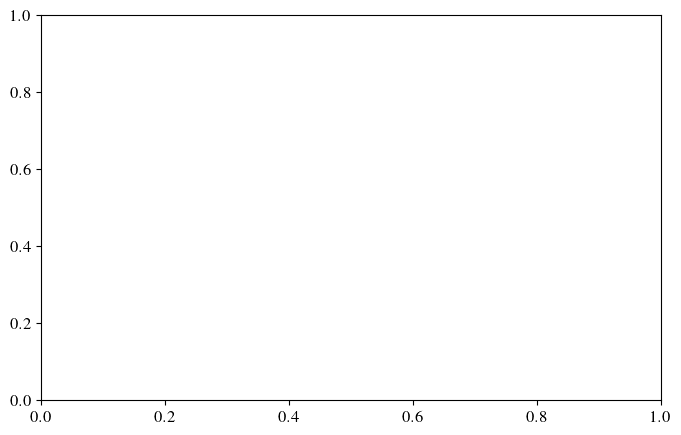

In [118]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8, 5))
n = len(angular_speed_means)

# Choose a colormap
cmap = plt.cm.get_cmap('rainbow', n)
# Create color list
colors = [cmap(i) for i in range(cmap.N)]
scalars = np.linspace(all_ages[0][0], all_ages[-1][0], n)
norm = plt.Normalize(min(scalars), max(scalars))
# Create a ScalarMappable and set array to the normalized values
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


# Assuming angular_speed_means is a list of lists
sec_to_yr = 3.154e7  # seconds in a year

# Use a nested list comprehension to multiply each inner element by sec_to_yr
angular_speed_means = [[speed * sec_to_yr for speed in sublist] for sublist in angular_speed_means]

# Do the same for pattern_speeds_radians_per_sec if it has the same structure
pattern_speeds_radians_per_sec = [[speed * sec_to_yr for speed in sublist] for sublist in pattern_speeds_radians_per_sec]


## Plot data ##
for j in range(len(angular_speed_means)):
    ax.plot(all_radii[j], angular_speed_means[j], label="Disc Angular Speed", linestyle="-", color=cmap(norm(scalars[j])))
for i in range(len(pattern_speeds)):
    lim_ps = 19 # limit the number of pattern speed points plotted
    ps = np.abs(pattern_speeds_radians_per_sec)[i][2:lim_ps]
    ax.plot(all_radii[i+1][2:lim_ps+6], np.abs(pattern_speeds_radians_per_sec)[i][2:lim_ps+6]*sec_to_yr, label="Pattern Speed", linestyle="dotted", color=cmap(norm(scalars[i])))
    ax.axhline(y=np.mean(ps), color=cmap(norm(scalars[i])), linestyle="--")

print("Minimum radius for pattern speed: " + str(all_radii[0][2]))

## Add colorbar ##
cbar = plt.colorbar(sm, ticks=np.linspace(min(scalars), max(scalars), n), ax=ax)
# Adjust the ticks and tick labels to start at the beginning of each color block
tick_locs = np.linspace(min(scalars), max(scalars), n+1)[:-1]  # Exclude the last tick for n colors
#tick_labels = [f'{np.round(scalar, ):.2f}' for scalar in tick_locations]
tick_labels = ['{:.3f}'.format(round(scalar, 3)) for scalar in tick_locs]
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)

## Add legend ##
# Define custom lines for the legend
legend_lines = [
    Line2D([0], [0], color='grey', linestyle='-', linewidth=2),
    Line2D([0], [0], color='grey', linestyle='dotted', linewidth=2),
    Line2D([0], [0], color='grey', linestyle='--', linewidth=2)
]
legend_labels = ['Disc Rotation Speed', 'm = 2 Pattern Speed', 'Mean Bar Pattern Speed']
ax.legend(legend_lines, legend_labels)

## Axes limits and labels ##
#plt.yscale("log")
#plt.ylim(1e-14, 1e-10)
plt.ylim(0, 0.1e-10)
#plt.xscale("log")    
plt.xlabel("Radius (pc)")
plt.ylabel("Speed (rad/syr)")

## Save and show ##
plt.title("Determining the Corotation Radius")
plt.savefig(f"corotation_radius/angular_and_pattern_speed_vs_radius_{all_ages[0][0]:.2f}_{all_ages[-1][0]:.2f}.png", bbox_inches="tight")
print(f"Saved plot to corotation_radius/angular_and_pattern_speed_vs_radius_{all_ages[0][0]:.2f}_{all_ages[-1][0]:.2f}_linear.png")
plt.show()

In [121]:
len(angular_speed_means)

4